# **DistilBert for movie spoiler text classification**
<br>

## **References:-**

[1] Hugging Face. (n.d.). Text Classification with Transformers. Retrieved from https://huggingface.co/distilbert-base-uncased <br>

[2] DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter https://arxiv.org/abs/1910.01108

## **Dataset**

[IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset).

The description provided on Kaggle:

*This dataset is collected from IMDB. It contains meta-data about items as well as user reviews with information regarding whether a review contains a spoiler or not.*

### In this notebook we are experimenting on the results of DistillBERT model on dataset with extra processed and 10% unsampled of the original data 

Importing the various standard library like sklearn, pandas, numpy, os, shutil

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
import os
import shutil

This below code imports several libraries for natural language processing (NLP) and data visualization tasks.
  * The **'transformers'** library is imported to use pre-trained models and tokenizers for NLP tasks. 
  * We import **'AutoTokenizer'** and **'TFAutoModelForSequenceClassification'** from **'transformers'** to tokenize text data and load a pre-trained model for sequence classification.
  * The **'json'** library is imported to work with JSON data, allowing us to read and write JSON files. 
  * The **'matplotlib.pyplot'** library is imported as **'plt'** to create visualizations, such as plots and charts. 
  * The **'random'** library is imported to generate random numbers or randomly shuffle data. 
  * The **'seaborn'** library is imported as 'sn' to enhance the visual appeal of plots created with 'matplotlib'. 
  * The **'tensorflow'** library is imported as 'tf' for building and training machine learning models, particularly in the context of deep learning. 
  
  By importing these libraries, we ensure that we have access to the necessary functions and tools for our NLP and data visualization tasks.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn
import tensorflow as tf

We need to load the processed data and hence we are mounting Google Drive in the notebook. Then we are loading the data which is **extra processed and 10% unsampled from the original data**. Next we are adding some shuffling to the data.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# /content/drive/MyDrive/cleaned_data.csv
data = pd.read_json("drive/MyDrive/extra_processed.json")
## Sample 10% Randomly
data = data.sample(int(0.1*len(data)))

Mounted at /content/drive


The **AutoTokenizer** class from the **Hugging Face** library is used to create a tokenizer. Specifically, the **distilbert-base-uncased** model is used as a pretrained tokenizer.

By calling AutoTokenizer.from_pretrained("distilbert-base-uncased"), the tokenizer is initialized with the pretrained model. This tokenizer is capable of transforming text inputs into numerical representations that can be processed by machine learning models.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") #Tokenizer

In [ ]:
texts = list(data["review_text"])

In [ ]:
texts

['christopher nolan teaches a great lesson here how to make a nearly perfect piece of cinamatic art based on a comic book the recipe is a magneficant actor for the main villain no need to praise that one could argue that heath ledger got overrated after his early death he truly gives a great performance here he portrays the menacing chaotic psycopath in a way that oldtime batman fan boys like myself watch the movie over and over just to see him again the storys shell is nothing new however its all coherent the atmosphere throughout the movie never fails to keep the watchers at the edge of their seats the characters are bar one to me all believable and fit in gotham city and the atmosphere perfectly a great actor is also needed for the title role christian bale is the best batman yet not that val kilmer or george clooney set the standards too high terrific musics and noises a deep disturbing melody or rhythm is always on in the background this manages to somehow darken the atmosphere ev

We then use the tokenizer on the imported dataset and store the tokenized data as tensor

In [ ]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text

We are converting labels with True or False output to 1 or 0 output which can be used easily for processing

In [ ]:
labels = list(data["is_spoiler"])
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)

def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

In [ ]:
batch_size=8 # define batch size

In [ ]:
indices = indicize_labels(labels) # make labels 1 or 0

We are creating TensorFlow dataset from the inputs and indices. We are spliting it into **30% validation** and **70% training** subsets, and applies batching with **batch size 8** and prefetching to the training subset.




In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.3*len(indices))
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

We are initializing a model for sequence classification using the pretrained **"distilbert-base-uncased"** architecture.


---


DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

We are using **BinaryCrossEntropy** as a loss measure and **BinaryAccuracy** as an accuracy measure



In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

The model is compiled using the Adam optimizer with a learning rate of 1e-5 and gradient clipping applied along with BinaryCrossentropy loss and BinaryAccuracy metric

We are then training the model for 6 epochs with the training and validation dataset defined above

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.), loss=loss, metrics=metrics)

In [ ]:
history=model.fit(train_ds, validation_data=val_ds, epochs=6, verbose=1)

Epoch 1/6
5021/5021 [==============================] - 2803s 553ms/step - loss: 0.4930 - binary_accuracy: 0.7630 - val_loss: 0.4734 - val_binary_accuracy: 0.7738
Epoch 2/6
5021/5021 [==============================] - 2721s 542ms/step - loss: 0.4429 - binary_accuracy: 0.7948 - val_loss: 0.4831 - val_binary_accuracy: 0.7808
Epoch 3/6
5021/5021 [==============================] - 2755s 549ms/step - loss: 0.3858 - binary_accuracy: 0.8336 - val_loss: 0.5339 - val_binary_accuracy: 0.7767
Epoch 4/6
5021/5021 [==============================] - 2720s 542ms/step - loss: 0.3227 - binary_accuracy: 0.8731 - val_loss: 0.6076 - val_binary_accuracy: 0.7686
Epoch 5/6
5021/5021 [==============================] - 2719s 542ms/step - loss: 0.2662 - binary_accuracy: 0.9037 - val_loss: 0.6924 - val_binary_accuracy: 0.7664
Epoch 6/6
5021/5021 [==============================] - 2718s 541ms/step - loss: 0.2256 - binary_accuracy: 0.9234 - val_loss: 0.7807 - val_binary_accuracy: 0.7691


We are saving this model to local drive to load this model after traning on the dataset

In [ ]:
model.save("Distillbert_unprocessed_6_epochs.tf")
import shutil
shutil.make_archive("Distillbert_5_epochs", 'zip', "Distillbert_unprocessed_6_epochs")


'/content/Distillbert_5_epochs.zip'

In [ ]:
indices = np.array(indices)

In [ ]:
print(indices.shape)

(57391,)


We are now testing the trained model on an example sentence. We tokenizing the text and feeding the tokenized input to the model. 

In [ ]:
text = "This is an example sentence."
encoded_input = tokenizer(text, return_tensors='tf')
input_ids = encoded_input['input_ids']
attention_mask = encoded_input['attention_mask']

# Obtain the predicted probabilities for each class
outputs = model(input_ids, attention_mask=attention_mask)
predicted_probabilities = tf.nn.softmax(outputs.logits)

In [ ]:
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.1405168]], dtype=float32)>, hidden_states=None, attentions=None)

In [ ]:
test_data = dataset.take(val_data_size-1)

##Classification report

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# Predict labels for test data
y_pred = model.predict(test_data)

17216/17216 [==============================] - 353s 21ms/step


In [ ]:
y_pred = tf.sigmoid(y_pred.logits)
y_pred = np.round(y_pred.numpy())
le = LabelEncoder()
test_labels = np.concatenate([y for x, y in val_ds], axis=0)
report = classification_report(test_labels, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.92      0.85     12626
           1       0.62      0.34      0.43      4590

    accuracy                           0.77     17216
   macro avg       0.71      0.63      0.64     17216
weighted avg       0.75      0.77      0.74     17216



##Plot of model accuracy vs epochs




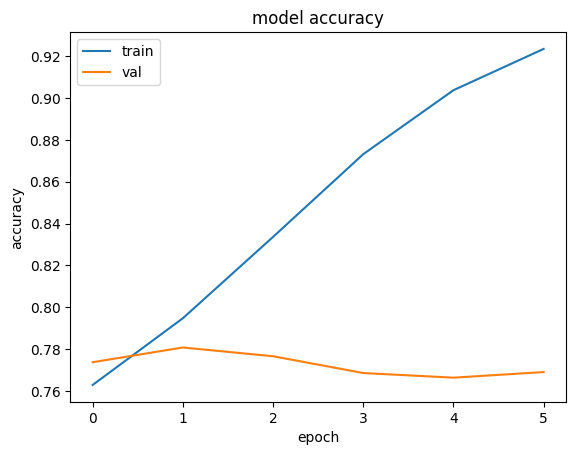

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Plot of model loss vs epochs




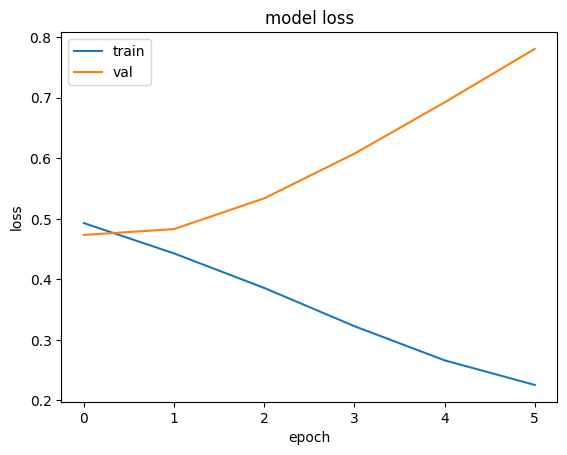

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Confusion matrix



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)

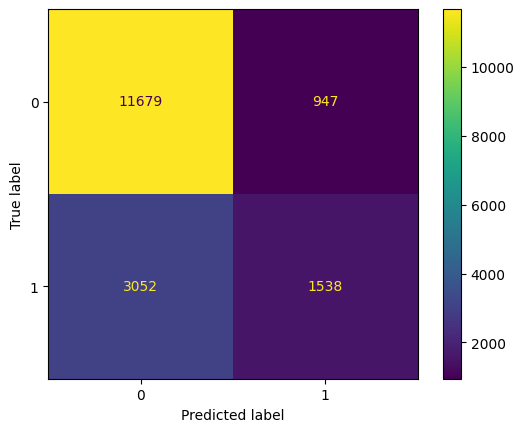

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()